In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from catboost import Pool, CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report

## Preprocess Dataset

In [3]:
# Read csv file
df = pd.read_csv('./dataset/train.csv')

# Get target value from 'Survived'
Y = df["Survived"].values

# Delete column 'PassengerId', 'Name', and 'Ticket' because they don't seems like a beneficial feature
df = df.drop(["PassengerId", "Survived", "Name", "Ticket"], axis=1)
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,NaN,S
1,1,female,38.0,1,0,71.2833,C85,C
2,3,female,26.0,0,0,7.9250,NaN,S
3,1,female,35.0,1,0,53.1000,C123,S
4,3,male,35.0,0,0,8.0500,NaN,S


In [4]:
df.shape

(891, 8)

In [5]:
# Get nan counts for each feature
print(df.isna().sum())

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64


In [6]:
# Delete column 'Age' and 'Cabin' because they have too much nan values
df = df.drop(["Age", "Cabin"], axis=1)

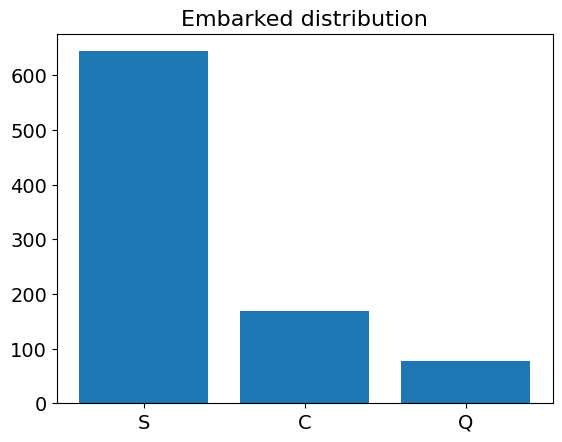

In [7]:
# Show the distribution of 'Embarked'
embarked_info = df["Embarked"].value_counts()
plt.bar(embarked_info.index, embarked_info.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Embarked distribution", fontsize=16);

In [8]:
# Fill the nan values of 'Embarked' with the most popular value
df["Embarked"].fillna("S", inplace=True)

In [9]:
# Map the categorical features of 'sex' and 'Embarked' to number
df["Sex"] = df["Sex"].map({"male": 1, "female": 0}).astype(int)    
df["Embarked"] = df["Embarked"].map({"S": 1, "C": 2, "Q": 3}).astype(int) 

In [10]:
# Add a column 'FamilySize' from column 'SibSp' and 'Parch'
df["FamilySize"] = df["SibSp"] + df["Parch"] + 1

# Add a column 'IsAlone' from column 'FamilySize'
df["IsAlone"] = df["FamilySize"].apply(lambda x: 1 if x == 1 else 0)

In [11]:
df.head()

,Pclass,Sex,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,3,1,1,0,7.2500,1,2,0
1,1,0,1,0,71.2833,2,2,0
2,3,0,0,0,7.9250,1,1,1
3,1,0,1,0,53.1000,1,2,0
4,3,1,0,0,8.0500,1,1,1


In [12]:
# Split dataset into train and test set
train_size = int(Y.shape[0] * 0.8)
X_train = df[:train_size]
X_test = df[train_size:]
Y_train = Y[:train_size]
Y_test = Y[train_size:]

print(f"Train X shape: {X_train.shape}")
print(f"Train y shape: {Y_train.shape}")
print(f"Test X shape: {X_test.shape}")
print(f"Train y shape: {Y_test.shape}")

Train X shape: (712, 8)
Train y shape: (712,)
Test X shape: (179, 8)
Train y shape: (179,)


## Catboost with original preprocessed dataset

In [19]:
# categorical features = ['Sex', 'Embarked', 'IsAlone']
cat_features = [1, 5, 7]

In [23]:
# GridSearchCV can do exhaustive search over specified parameter values for an estimator.
# Parameters for GridSearchCV
parameters = {
    'iterations': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.3],
    'depth': [9, 11, 13],
}

# Define classifier model
catboost_model = CatBoostClassifier(
    verbose=50,
    cat_features=cat_features,
)

# Do GridSearchCV on model
catboost_model = GridSearchCV(
    catboost_model, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

# Train model
catboost_model.fit(X_train, Y_train)

print(catboost_model.best_params_)
print(catboost_model.best_score_)

0:	learn: 0.6761369	total: 4.72ms	remaining: 231ms
25:	learn: 0.4825823	total: 332ms	remaining: 307ms
49:	learn: 0.4360665	total: 617ms	remaining: 0us
0:	learn: 0.6751909	total: 10.2ms	remaining: 500ms
25:	learn: 0.4761701	total: 296ms	remaining: 273ms
49:	learn: 0.4273290	total: 616ms	remaining: 0us
0:	learn: 0.6764722	total: 10.1ms	remaining: 496ms
25:	learn: 0.4950154	total: 311ms	remaining: 287ms
49:	learn: 0.4540208	total: 599ms	remaining: 0us
0:	learn: 0.6770863	total: 10.3ms	remaining: 506ms
25:	learn: 0.4882863	total: 333ms	remaining: 307ms
49:	learn: 0.4450458	total: 681ms	remaining: 0us
0:	learn: 0.6757987	total: 12.9ms	remaining: 632ms
25:	learn: 0.4870752	total: 332ms	remaining: 307ms
49:	learn: 0.4429909	total: 619ms	remaining: 0us
0:	learn: 0.6599355	total: 6.8ms	remaining: 333ms
25:	learn: 0.4363827	total: 319ms	remaining: 294ms
49:	learn: 0.4069222	total: 631ms	remaining: 0us
0:	learn: 0.6580100	total: 10.7ms	remaining: 526ms
25:	learn: 0.4247617	total: 341ms	remaining:

25:	learn: 0.4247617	total: 326ms	remaining: 1.55s
50:	learn: 0.3958276	total: 634ms	remaining: 1.23s
75:	learn: 0.3741368	total: 948ms	remaining: 923ms
100:	learn: 0.3574297	total: 1.3s	remaining: 633ms
125:	learn: 0.3438590	total: 1.66s	remaining: 316ms
149:	learn: 0.3343664	total: 2s	remaining: 0us
0:	learn: 0.6604981	total: 10.1ms	remaining: 1.51s
25:	learn: 0.4493240	total: 311ms	remaining: 1.48s
50:	learn: 0.4235722	total: 614ms	remaining: 1.19s
75:	learn: 0.4125605	total: 929ms	remaining: 904ms
100:	learn: 0.3990013	total: 1.25s	remaining: 609ms
125:	learn: 0.3870659	total: 1.68s	remaining: 319ms
149:	learn: 0.3770189	total: 2.01s	remaining: 0us
0:	learn: 0.6616611	total: 10.7ms	remaining: 1.6s
25:	learn: 0.4389719	total: 331ms	remaining: 1.58s
50:	learn: 0.4081340	total: 659ms	remaining: 1.28s
75:	learn: 0.3899705	total: 985ms	remaining: 959ms
100:	learn: 0.3798055	total: 1.34s	remaining: 649ms
125:	learn: 0.3709633	total: 1.69s	remaining: 322ms
149:	learn: 0.3615441	total: 2.0

25:	learn: 0.3639983	total: 451ms	remaining: 1.28s
50:	learn: 0.3125373	total: 981ms	remaining: 943ms
75:	learn: 0.2811747	total: 1.5s	remaining: 476ms
99:	learn: 0.2572823	total: 2s	remaining: 0us
0:	learn: 0.6035442	total: 18ms	remaining: 1.78s
25:	learn: 0.4001342	total: 444ms	remaining: 1.26s
50:	learn: 0.3535793	total: 973ms	remaining: 935ms
75:	learn: 0.3205395	total: 1.49s	remaining: 472ms
99:	learn: 0.3026211	total: 2.02s	remaining: 0us
0:	learn: 0.6062601	total: 11.1ms	remaining: 1.09s
25:	learn: 0.3830779	total: 443ms	remaining: 1.26s
50:	learn: 0.3403894	total: 944ms	remaining: 907ms
75:	learn: 0.3128006	total: 1.45s	remaining: 459ms
99:	learn: 0.2850788	total: 1.95s	remaining: 0us
0:	learn: 0.5999743	total: 13.1ms	remaining: 1.3s
25:	learn: 0.3901564	total: 419ms	remaining: 1.19s
50:	learn: 0.3446559	total: 937ms	remaining: 900ms
75:	learn: 0.3175632	total: 1.45s	remaining: 457ms
99:	learn: 0.2953596	total: 1.98s	remaining: 0us
0:	learn: 0.6761369	total: 4.68ms	remaining: 6

49:	learn: 0.3431375	total: 1.52s	remaining: 0us
0:	learn: 0.6062601	total: 10.4ms	remaining: 510ms
25:	learn: 0.3569947	total: 726ms	remaining: 670ms
49:	learn: 0.3232767	total: 1.52s	remaining: 0us
0:	learn: 0.5999743	total: 11.9ms	remaining: 586ms
25:	learn: 0.3784209	total: 737ms	remaining: 681ms
49:	learn: 0.3287077	total: 1.68s	remaining: 0us
0:	learn: 0.6761369	total: 4.81ms	remaining: 477ms
25:	learn: 0.4817874	total: 447ms	remaining: 1.27s
50:	learn: 0.4322323	total: 948ms	remaining: 911ms
75:	learn: 0.4099299	total: 1.48s	remaining: 468ms
99:	learn: 0.3963033	total: 2.05s	remaining: 0us
0:	learn: 0.6751909	total: 10.2ms	remaining: 1s
25:	learn: 0.4783937	total: 459ms	remaining: 1.31s
50:	learn: 0.4245337	total: 953ms	remaining: 916ms
75:	learn: 0.3987945	total: 1.47s	remaining: 464ms
99:	learn: 0.3831515	total: 2.12s	remaining: 0us
0:	learn: 0.6764722	total: 10.9ms	remaining: 1.08s
25:	learn: 0.4952023	total: 369ms	remaining: 1.05s
50:	learn: 0.4496916	total: 881ms	remaining:

75:	learn: 0.2664944	total: 2.53s	remaining: 2.47s
100:	learn: 0.2452848	total: 3.39s	remaining: 1.64s
125:	learn: 0.2238136	total: 4.26s	remaining: 811ms
149:	learn: 0.2098749	total: 5.17s	remaining: 0us
0:	learn: 0.6035442	total: 10.8ms	remaining: 1.61s
25:	learn: 0.3930853	total: 662ms	remaining: 3.15s
50:	learn: 0.3401218	total: 1.57s	remaining: 3.05s
75:	learn: 0.3109032	total: 2.42s	remaining: 2.36s
100:	learn: 0.2894905	total: 3.31s	remaining: 1.6s
125:	learn: 0.2719763	total: 4.25s	remaining: 809ms
149:	learn: 0.2576263	total: 5.14s	remaining: 0us
0:	learn: 0.6062601	total: 12.3ms	remaining: 1.84s
25:	learn: 0.3569947	total: 772ms	remaining: 3.68s
50:	learn: 0.3213456	total: 1.53s	remaining: 2.97s
75:	learn: 0.2926526	total: 2.39s	remaining: 2.33s
100:	learn: 0.2662622	total: 3.21s	remaining: 1.56s
125:	learn: 0.2496274	total: 4.09s	remaining: 780ms
149:	learn: 0.2322424	total: 4.94s	remaining: 0us
0:	learn: 0.5999743	total: 10.4ms	remaining: 1.56s
25:	learn: 0.3784209	total: 7

100:	learn: 0.4067832	total: 4.05s	remaining: 1.97s
125:	learn: 0.3961955	total: 5.41s	remaining: 1.03s
149:	learn: 0.3840204	total: 7.06s	remaining: 0us
0:	learn: 0.6770863	total: 11.2ms	remaining: 1.67s
25:	learn: 0.4884385	total: 423ms	remaining: 2.02s
50:	learn: 0.4366714	total: 1.16s	remaining: 2.25s
75:	learn: 0.4114829	total: 2.4s	remaining: 2.33s
100:	learn: 0.3941727	total: 3.85s	remaining: 1.87s
125:	learn: 0.3809209	total: 5.35s	remaining: 1.02s
149:	learn: 0.3672035	total: 7.09s	remaining: 0us
0:	learn: 0.6757987	total: 11.3ms	remaining: 1.68s
25:	learn: 0.4920678	total: 470ms	remaining: 2.24s
50:	learn: 0.4417402	total: 1.43s	remaining: 2.78s
75:	learn: 0.4174694	total: 2.42s	remaining: 2.36s
100:	learn: 0.4024333	total: 3.8s	remaining: 1.84s
125:	learn: 0.3891639	total: 5.44s	remaining: 1.04s
149:	learn: 0.3769715	total: 7.18s	remaining: 0us
0:	learn: 0.6599355	total: 4.48ms	remaining: 668ms
25:	learn: 0.4289746	total: 715ms	remaining: 3.41s
50:	learn: 0.3901762	total: 1.

In [27]:
# Get metric scores
def get_metric_results(test_label, predict_label):
    metric_results = {}
    metric_results['accuracy'] = accuracy_score(test_label, predict_label)
    metric_results['f1_score'] = f1_score(test_label, predict_label, average="macro")
    metric_results['precision'] = precision_score(test_label, predict_label, average="macro")
    metric_results['recall'] = recall_score(test_label, predict_label, average="macro")
    return metric_results

In [36]:
prediction = catboost_model.predict(X_test)
print(get_metric_results(Y_test, prediction))

{'accuracy': 0.8324022346368715, 'f1_score': 0.8103813559322033, 'precision': 0.8274074074074074, 'recall': 0.8002717391304348}


## One-hot encode and Standardize Dataset

In [29]:
# Do one-hot encoding on 'Pclass' and 'Embarked'
one_hot_cols = ["Pclass", "Embarked"]
for col in one_hot_cols:
    df = pd.concat(
        [df, pd.get_dummies(df[col], prefix=col)], 
        axis=1, 
        join="inner",
    )
df = df.drop(one_hot_cols, axis=1)

In [30]:
# Standardize dataset
scaler = StandardScaler()
df.loc[:] = scaler.fit_transform(df)

In [31]:
df.head()

,Sex,SibSp,Parch,Fare,FamilySize,IsAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_1,Embarked_2,Embarked_3
0,0.737695,0.432793,-0.473674,-0.502445,0.059160,-1.231645,-0.565685,-0.510152,0.902587,0.615838,-0.482043,-0.307562
1,-1.355574,0.432793,-0.473674,0.786845,0.059160,-1.231645,1.767767,-0.510152,-1.107926,-1.623803,2.074505,-0.307562
2,-1.355574,-0.474545,-0.473674,-0.488854,-0.560975,0.811922,-0.565685,-0.510152,0.902587,0.615838,-0.482043,-0.307562
3,-1.355574,0.432793,-0.473674,0.420730,0.059160,-1.231645,1.767767,-0.510152,-1.107926,0.615838,-0.482043,-0.307562
4,0.737695,-0.474545,-0.473674,-0.486337,-0.560975,0.811922,-0.565685,-0.510152,0.902587,0.615838,-0.482043,-0.307562


In [33]:
# New train and test set after one-hot encoding and standardization
X_train_norm = df[:Y_train.shape[0]]
X_test_norm = df[Y_train.shape[0]:]

print(f"Train norm X shape: {X_train_norm.shape}")
print(f"Test norm X shape: {X_test_norm.shape}")

Train norm X shape: (712, 12)
Test norm X shape: (179, 12)


## SVC with new dataset

In [35]:
# GridSearchCV can do exhaustive search over specified parameter values for an estimator.
# Parameters for GridSearchCV
parameters = {
    "C": [0.001, 0.01, 0.1, 1.],
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "gamma": ["scale", "auto"],
}

# Define classifier model
svc_model = SVC(
    random_state=42,
    class_weight="balanced",
    probability=True,
)

# Do GridSearchCV on model
svc_model = GridSearchCV(
    svc_model, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

# Train model
svc_model.fit(X_train_norm, Y_train)

print(svc_model.best_params_)
print(svc_model.best_score_)

{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.7921599527233331


In [37]:
prediction = svc_model.predict(X_test_norm)
print(get_metric_results(Y_test, prediction))

{'accuracy': 0.8379888268156425, 'f1_score': 0.8067170570056224, 'precision': 0.8615766073871409, 'recall': 0.7872961956521739}


## KNN with new dataset

In [39]:
# GridSearchCV can do exhaustive search over specified parameter values for an estimator.
# Parameters for GridSearchCV
parameters = {
    "weights": ["uniform", "distance"],
}

# Define classifier model
knn_model = KNeighborsClassifier()

# Do GridSearchCV on model
knn_model = GridSearchCV(
    knn_model, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

# Train model
knn_model.fit(X_train_norm, Y_train)

print(knn_model.best_params_)
print(knn_model.best_score_)

{'weights': 'distance'}
0.7950162513542794


In [40]:
prediction = knn_model.predict(X_test_norm)
print(get_metric_results(Y_test, prediction))

{'accuracy': 0.8491620111731844, 'f1_score': 0.83146772674966, 'precision': 0.8426085706068449, 'recall': 0.8237092391304348}


## Catboost with new dataset

In [43]:
# GridSearchCV can do exhaustive search over specified parameter values for an estimator.
# Parameters for GridSearchCV
parameters = {
    'iterations': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.3],
    'depth': [9, 11, 13],
}

# Define classifier model
catboost_model = CatBoostClassifier(
    verbose=50,
    cat_features=[],
)

# Do GridSearchCV on model
catboost_model = GridSearchCV(
    catboost_model, 
    parameters, 
    cv=5,
    scoring='accuracy',
)

# Train model
catboost_model.fit(X_train_norm, Y_train)

print(catboost_model.best_params_)
print(catboost_model.best_score_)

0:	learn: 0.6750708	total: 878us	remaining: 43.1ms
49:	learn: 0.4316359	total: 170ms	remaining: 0us
0:	learn: 0.6746183	total: 1.83ms	remaining: 89.6ms
49:	learn: 0.4219199	total: 182ms	remaining: 0us
0:	learn: 0.6764963	total: 1.56ms	remaining: 76.4ms
49:	learn: 0.4488470	total: 166ms	remaining: 0us
0:	learn: 0.6776594	total: 410us	remaining: 20.1ms
49:	learn: 0.4380142	total: 137ms	remaining: 0us
0:	learn: 0.6767941	total: 830us	remaining: 40.7ms
49:	learn: 0.4381338	total: 213ms	remaining: 0us
0:	learn: 0.6578376	total: 795us	remaining: 39ms
49:	learn: 0.3956779	total: 182ms	remaining: 0us
0:	learn: 0.6569399	total: 1.49ms	remaining: 73ms
49:	learn: 0.3797560	total: 204ms	remaining: 0us
0:	learn: 0.6606025	total: 1.7ms	remaining: 83.1ms
49:	learn: 0.4141760	total: 190ms	remaining: 0us
0:	learn: 0.6629192	total: 457us	remaining: 22.4ms
49:	learn: 0.3982169	total: 196ms	remaining: 0us
0:	learn: 0.6612304	total: 428us	remaining: 21ms
49:	learn: 0.4037181	total: 161ms	remaining: 0us
0:	

49:	learn: 0.3189497	total: 627ms	remaining: 0us
0:	learn: 0.6750708	total: 664us	remaining: 65.8ms
50:	learn: 0.4288199	total: 473ms	remaining: 454ms
99:	learn: 0.3936337	total: 865ms	remaining: 0us
0:	learn: 0.6746183	total: 1.93ms	remaining: 191ms
50:	learn: 0.4165577	total: 520ms	remaining: 499ms
99:	learn: 0.3752169	total: 1.08s	remaining: 0us
0:	learn: 0.6764963	total: 1.57ms	remaining: 156ms
50:	learn: 0.4449539	total: 486ms	remaining: 467ms
99:	learn: 0.4098150	total: 1.07s	remaining: 0us
0:	learn: 0.6776594	total: 599us	remaining: 59.4ms
50:	learn: 0.4328725	total: 413ms	remaining: 397ms
99:	learn: 0.3917070	total: 1000ms	remaining: 0us
0:	learn: 0.6767941	total: 394us	remaining: 39.1ms
50:	learn: 0.4381990	total: 492ms	remaining: 473ms
99:	learn: 0.3978931	total: 1s	remaining: 0us
0:	learn: 0.6578376	total: 577us	remaining: 57.2ms
50:	learn: 0.3919203	total: 511ms	remaining: 491ms
99:	learn: 0.3427459	total: 1.15s	remaining: 0us
0:	learn: 0.6569399	total: 1.34ms	remaining: 13

50:	learn: 0.3913156	total: 1.61s	remaining: 1.58s
99:	learn: 0.3433629	total: 3.87s	remaining: 0us
0:	learn: 0.5974254	total: 619us	remaining: 61.4ms
50:	learn: 0.3073294	total: 2.06s	remaining: 2.06s
99:	learn: 0.2533121	total: 4.85s	remaining: 0us
0:	learn: 0.5947400	total: 1.33ms	remaining: 131ms
50:	learn: 0.2896793	total: 2.24s	remaining: 2.15s
99:	learn: 0.2328180	total: 5s	remaining: 0us
0:	learn: 0.6046423	total: 1.36ms	remaining: 135ms
50:	learn: 0.3213431	total: 2.02s	remaining: 1.94s
99:	learn: 0.2650206	total: 4.74s	remaining: 0us
0:	learn: 0.6115085	total: 420us	remaining: 41.6ms
50:	learn: 0.2992108	total: 1.87s	remaining: 1.8s
99:	learn: 0.2358615	total: 4.66s	remaining: 0us
0:	learn: 0.6069666	total: 465us	remaining: 46.1ms
50:	learn: 0.3015055	total: 2.32s	remaining: 2.28s
99:	learn: 0.2506824	total: 5.27s	remaining: 0us
0:	learn: 0.6750708	total: 698us	remaining: 104ms
50:	learn: 0.4315258	total: 1.05s	remaining: 2.05s
100:	learn: 0.3920453	total: 2.23s	remaining: 1.

In [45]:
prediction = catboost_model.predict(X_test_norm)
print(get_metric_results(Y_test, prediction))

{'accuracy': 0.8491620111731844, 'f1_score': 0.8285987871050111, 'precision': 0.8491314764899671, 'recall': 0.8167798913043478}
